CARND - Traffic Sign Classification Project
==================================
German traffic sign classification  as a part of the Self-driving Car Nanodegree program at Udacity using LeNet architecture.

-----------
### Step 0: Load the data

In [10]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

from matplotlib import pyplot as plt
import pandas as pd
import random
import numpy as np
import tensorflow as tf
import math

from src import loading, utils, lenet, preprocessing, augmentation
from src.lenet import HYPER_PARAMETERS, Mode
from sklearn.utils import shuffle
logger = utils.get_logger('Main Notebook')

In [11]:
training, validation, test = loading.load_all()

-------
### Step 1: Dataset Summary & Exploration

Task: provide a basic summary of the dataset, including an exploratory visualisation of the data set.

In [12]:
summary = utils.get_summary([training, validation, test])
print(summary)

{'TRAINING': {'image-shape': (32, 32, 3), 'number-of-examples': 34799, 'no-of-classes': 43}, 'VALIDATION': {'image-shape': (32, 32, 3), 'number-of-examples': 4410, 'no-of-classes': 43}, 'total-no-of-classes': 43, 'TEST': {'image-shape': (32, 32, 3), 'number-of-examples': 12630, 'no-of-classes': 43}}


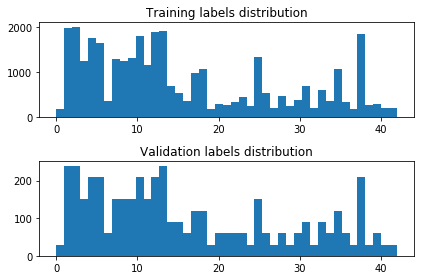

In [13]:
plt.subplot(211)
plt.hist(training.y, bins=summary['total-no-of-classes']);
plt.title('Training labels distribution');

plt.subplot(212)
plt.hist(validation.y, bins=summary['total-no-of-classes']);
plt.title('Validation labels distribution');
plt.tight_layout()
plt.savefig('./docs/images/training-validation-histogram.jpg')

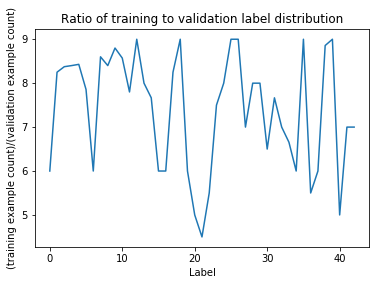

In [14]:
# Show that training/validation is somehow balanced
y_train_counts = utils.group_labels_by_counts(training)
y_validation_counts = utils.group_labels_by_counts(validation)
plt.plot(y_train_counts['counts']/ y_validation_counts['counts']);
plt.title('Ratio of training to validation label distribution');
plt.xlabel('Label');
plt.ylabel('(training example count)/(validation example count)');
plt.savefig('./docs/images/training-validation-sample-size-ratios.jpg')

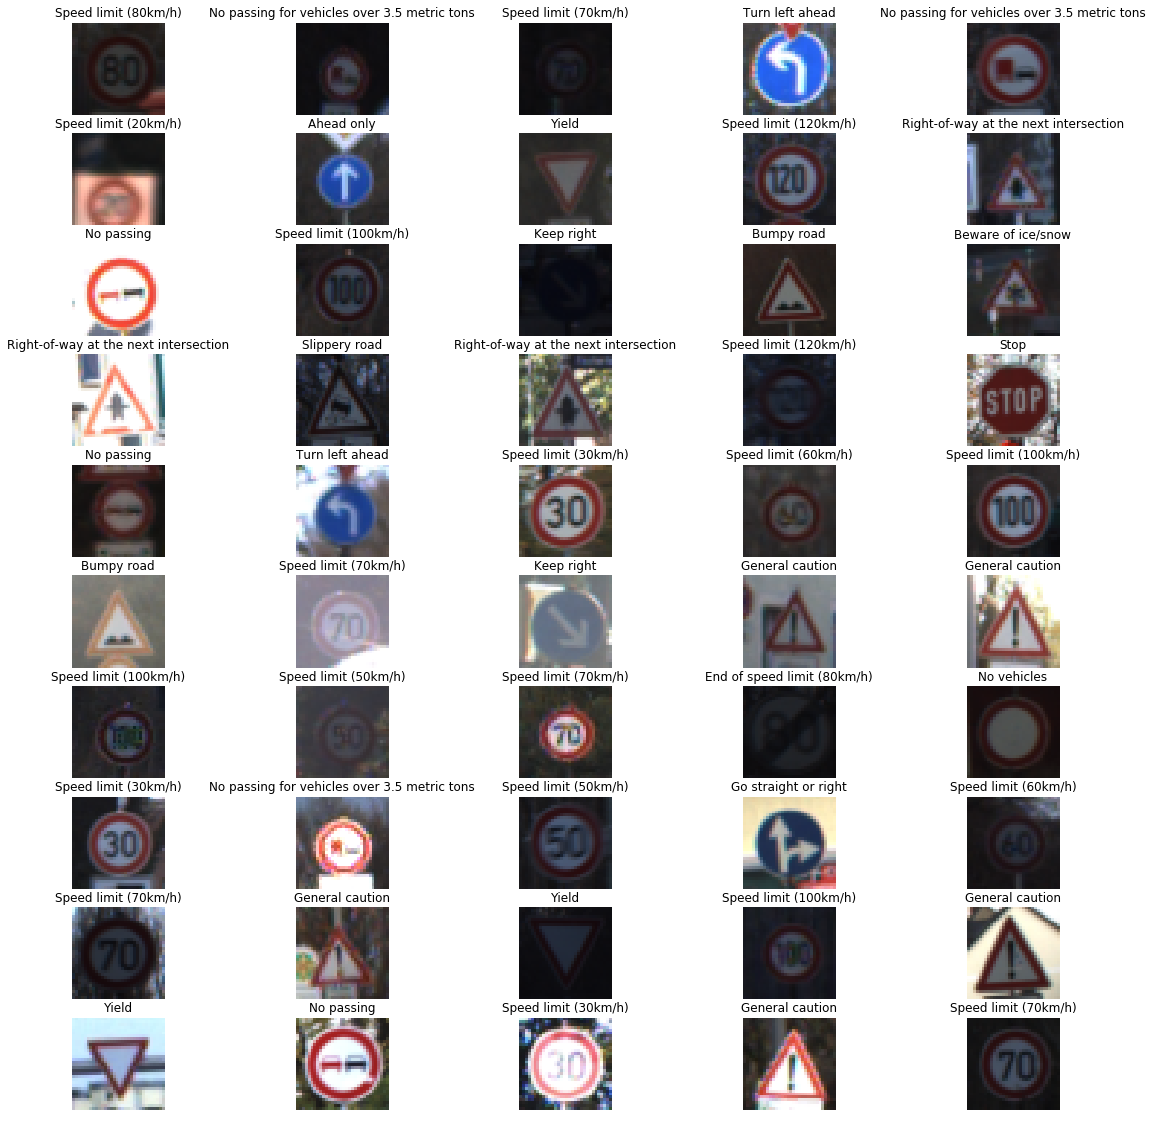

In [15]:
images = []
labels = []
for i in range(50):
    index = random.randint(0, training.count)
    images.append(training.X[index])
    labels.append(utils.to_sign_label(training.y[index]))
utils.plot_and_save(images, labels, './docs/images/25-random-images.jpg', 5)

['No passing for vehicles over 3.5 metric tons', 'Keep right', 'Yield', 'Roundabout mandatory']


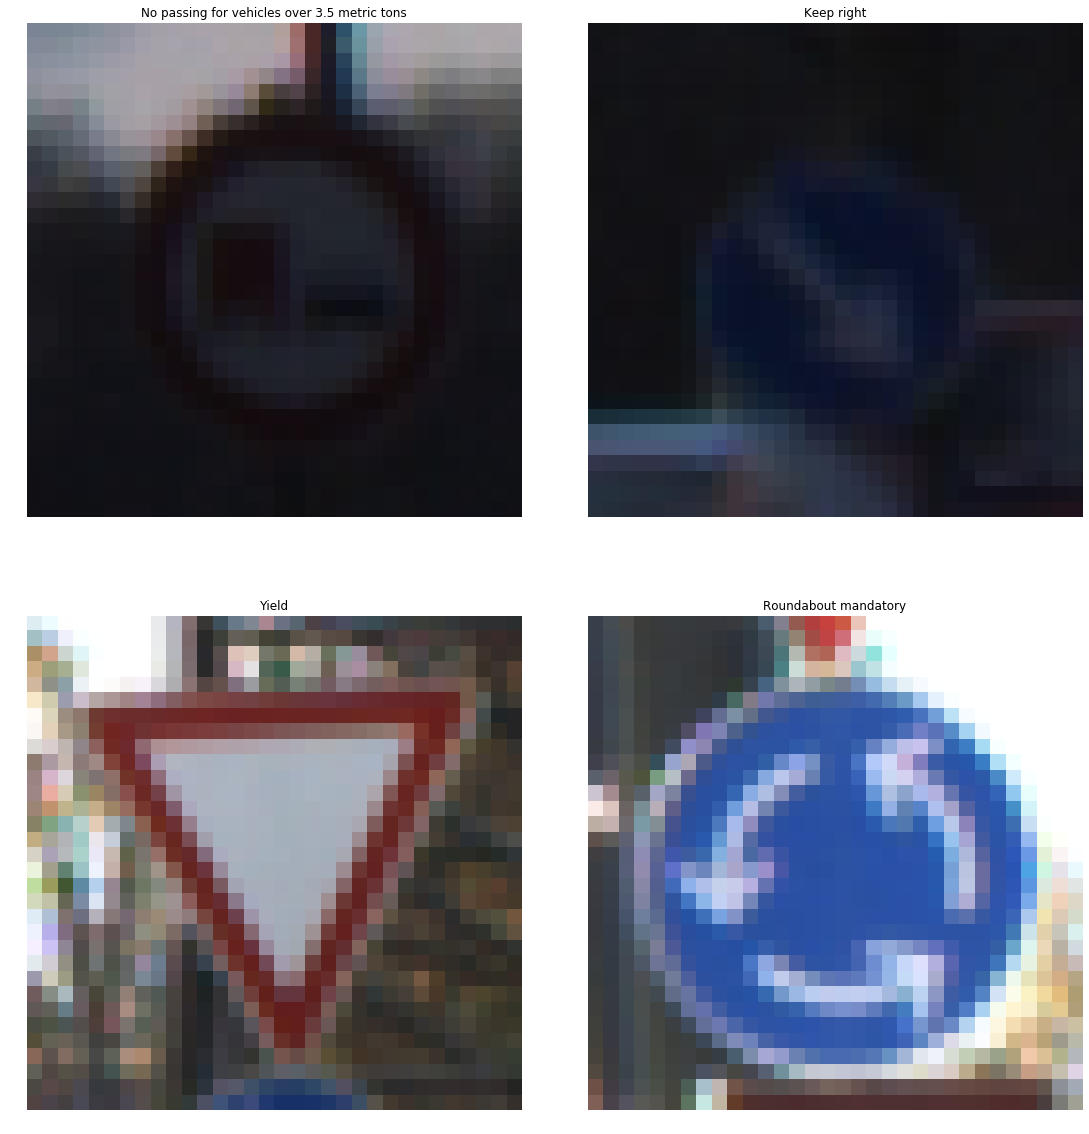

In [16]:
example_images = {
    'with bad lighting': [17894, 14044],
    'good': [22842, 4220]
}
images = []
labels = []
for label, indices in example_images.items():
    for i in indices:
        images.append(training.X[i])
        labels.append(utils.to_sign_label(training.y[i]))

print(labels)
utils.plot_and_save(images, labels, 'docs/images/cherry-pick-good-bad-images.jpg', 2)

----

## Step 2: Design and Test a Model Architecture

#### Pre-process and augment dataset

In [17]:
# List of enabled data augmenters for training data set
TRAINING_DATA_AUGMENTERS = [
    augmentation.HorizontalFlipper(),
    augmentation.AffineTransformAugmenter(),
#     augmentation.GaussianBlurAugmenter(),
    augmentation.RandomScalerAugmenter()
]
print('Original: ', utils.get_summary([training]))

d_train = augmentation.augment_data_set(training, TRAINING_DATA_AUGMENTERS)
print('Augmented: ', utils.get_summary([d_train]))

Original:  {'TRAINING': {'image-shape': (32, 32, 3), 'number-of-examples': 34799, 'no-of-classes': 43}, 'total-no-of-classes': 43}
Augmented:  {'TRAINING': {'image-shape': (32, 32, 3), 'number-of-examples': 278392, 'no-of-classes': 43}, 'total-no-of-classes': 43}


In [ ]:
# List of enabled data pre-processors
PRE_PROCESSORS = [
    preprocessing.GrayScaleConverter(),
    preprocessing.ZNormaliser(),
]

# Perform pre-processing on augmented training and validation data sets
d_train = preprocessing.PreProcessor.apply(d_train, PRE_PROCESSORS)
d_validation = preprocessing.PreProcessor.apply(validation, PRE_PROCESSORS)

In [ ]:
# Apply pre-processing to two of the "bad" images to show the results
BAD_IMAGE_INDEX = [17894, 14044]

bad_x = np.zeros((2, 32, 32, 3))
bad_y = np.zeros(2,)
for i in range(len(BAD_IMAGE_INDEX)):
    bad_x[i,:] = training.X[BAD_IMAGE_INDEX[i]]
    bad_y[i] = training.y[BAD_IMAGE_INDEX[i]]
bad_examples = loading.DataSet('bad_samples', bad_x, bad_y, len(bad_x))

pre_processed = preprocessing.PreProcessor.apply(bad_examples, PRE_PROCESSORS)

images = []
labels = []
for i in range(len(BAD_IMAGE_INDEX)):
    images.append(training.X[BAD_IMAGE_INDEX[i]]);
    labels.append('Original')

    images.append(pre_processed.X[i].squeeze());
    labels.append('Pre-processed')
utils.plot_and_save(images, labels, './docs/images/bad-images-pre-processed.jpg', 2)

#### Initialize Placeholders and setup computation graph

In [21]:
tf.reset_default_graph()

x = tf.placeholder(tf.float32, (None, 32, 32, 1))
y = tf.placeholder(tf.int32, (None))
mode = tf.placeholder(tf.string, (None))

training_operation, accuracy_operation, logits = lenet.setup_graph(x, y, mode)

2019-03-12 22:38:16 INFO     Running LeNet in Tensor("Placeholder_2:0", dtype=string) mode with keep probability of Tensor("cond/Merge:0", shape=(), dtype=float32)...


#### Start training

In [ ]:
logger.info('Hyper-parameters: %s', HYPER_PARAMETERS)

# TODO: this override is just for local testing - remove it in the final version
HYPER_PARAMETERS['EPOCHS'] = 1

saver = tf.train.Saver()
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = d_train.count

    logger.info("Training...")
    for i in range(HYPER_PARAMETERS['EPOCHS']):
        X_train, y_train = shuffle(d_train.X, d_train.y)
        training_accuracy = 0
        for offset in range(0, num_examples, HYPER_PARAMETERS['BATCH_SIZE']):
            end = offset + HYPER_PARAMETERS['BATCH_SIZE']
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, mode: Mode.TRAINING.value})

        training_accuracy = lenet.evaluation(d_train.X, d_train.y, x, y, mode, accuracy_operation)
        validation_accuracy = lenet.evaluation(d_validation.X, d_validation.y, x, y, mode, accuracy_operation)
        logger.info("EPOCH {} ...".format(i + 1))
        logger.info("Accuracy on training dataset = {:.3f}".format(training_accuracy))
        logger.info("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()

    saver.save(sess, './data/model/lenet')
    logger.info("Model saved")



---
## Step 3: Test a Model on New Images

To give yourself more insight into how your model is working, download at least five pictures of German traffic signs from the web and use your model to predict the traffic sign type.

### Load and Output the Images

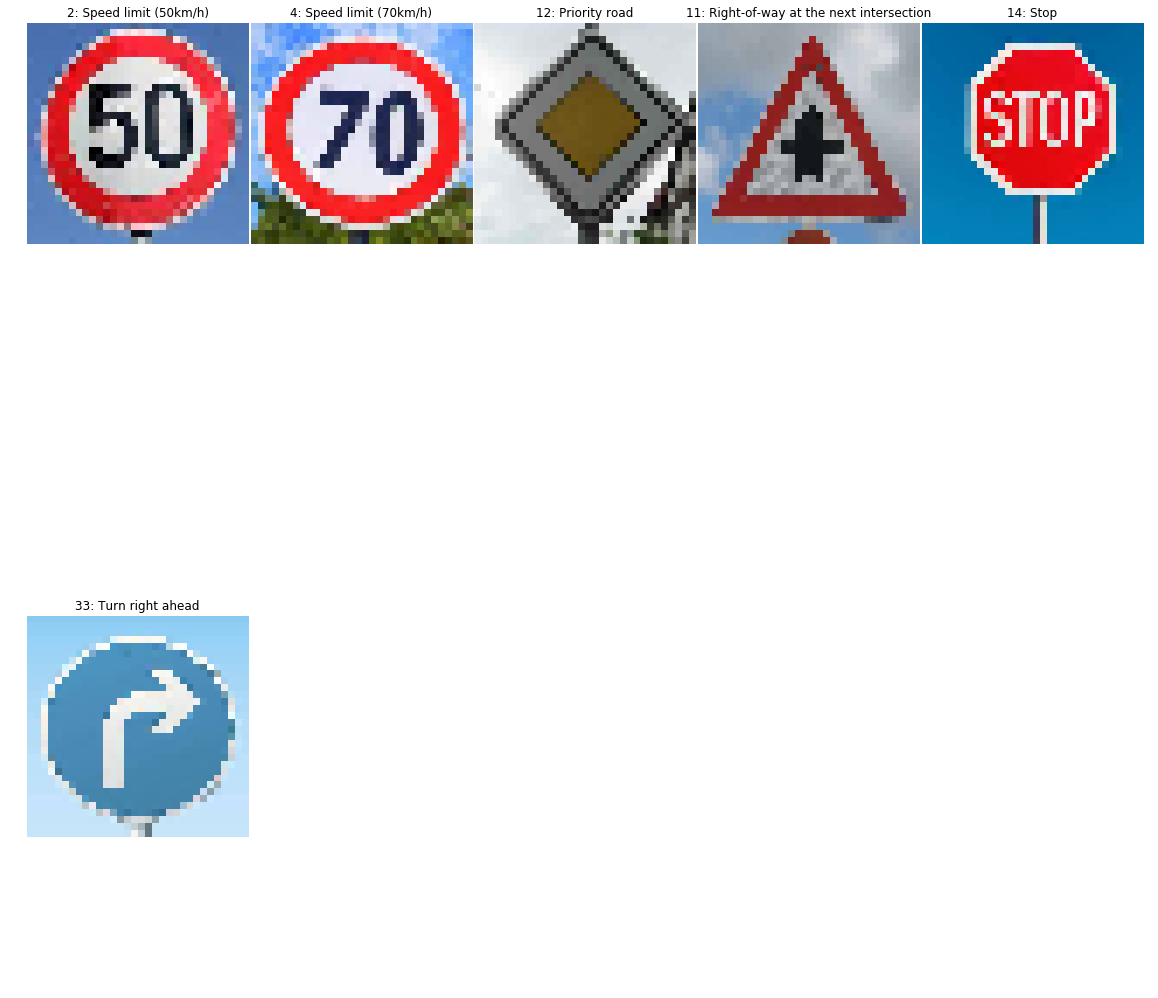

In [125]:
FROM_INTERNET_IMAGE_PATHS = [
    "max-50.jpeg",
    "max-70.jpeg",
    "priority-road.jpg",
    "right-of-way-at-next-intersection.jpg",
    "stop.jpg",
    "turn-right-ahead.jpg"
]
FROM_INTERNET_LABELS = [2, 4, 12, 11, 14, 33]
from_internet_images = [utils.read_image_for_lenet('./data/traffic-signs-from-internet/' + p) for p in FROM_INTERNET_IMAGE_PATHS]

plt_labels = ['{}: {}'.format(l, utils.to_sign_label(l)) for l in FROM_INTERNET_LABELS]
utils.plot_and_save(from_internet_images, plt_labels, './docs/images/images-from-internet-resized.jpg', 5)

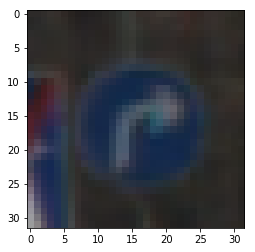

In [121]:
df = pd.DataFrame(training.y)
indices = df.loc[df[0] == 33].reset_index()
plt.imshow(training.X[indices['index'][10], :])

### Predict the Sign Type for Each Image

In [122]:
d_x = np.stack(from_internet_images)
d_y = np.array(FROM_INTERNET_LABELS)

from_internet_dataset = loading.DataSet('From Internet', d_x, d_y, len(d_x))
logger.info(utils.get_summary([from_internet_dataset]))
from_internet_dataset = preprocessing.PreProcessor.apply(from_internet_dataset, PRE_PROCESSORS)


softmax_logits = tf.nn.softmax(logits)
top_k = tf.nn.top_k(softmax_logits, k=10)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver2 = tf.train.import_meta_graph('./data/model/lenet.meta')
    saver2.restore(sess, "./data/model/lenet")
    
    softmax_values = sess.run(softmax_logits, feed_dict={x: from_internet_dataset.X, mode: Mode.PREDICTING.value})
    top_k_results = sess.run(top_k, feed_dict={x: from_internet_dataset.X, mode: Mode.PREDICTING.value})

2019-03-12 23:54:57 INFO     {'total-no-of-classes': 6, 'From Internet': {'image-shape': (32, 32, 3), 'number-of-examples': 6, 'no-of-classes': 6}}
2019-03-12 23:54:57 INFO     {'total-no-of-classes': 6, 'From Internet': {'image-shape': (32, 32, 3), 'number-of-examples': 6, 'no-of-classes': 6}}
2019-03-12 23:54:57 INFO     Running Z_NORMALISATION on From Internet dataset...
2019-03-12 23:54:57 INFO     	Parameters: null
2019-03-12 23:54:57 INFO     Normalising From Internet with mean: 78.72657203958035 and sigma: 66.30883086498567...
2019-03-12 23:54:57 INFO     Running TO_GRAY_SCALE on From Internet dataset...
2019-03-12 23:54:57 INFO     	Parameters: {"channel-weights": [0.299, 0.587, 0.114]}
INFO:tensorflow:Restoring parameters from ./data/model/lenet


### Analyze performance

In [123]:
print('Expected: {}'.format(FROM_INTERNET_LABELS))
print('Actual: {}'.format(top_k_results.indices[:, 0]))
print('Probabilities: {}'.format(top_k_results.values[:, 0]))

Expected: [2, 4, 12, 11, 14, 33]
Actual: [0 5 5 5 0 0]
Probabilities: [0.835454   0.85014474 0.5686003  0.2333342  0.2704598  0.6398376 ]


### Output Top 5 Softmax Probabilities For Each Image Found on the Web

In [124]:
for i in range(top_k_results.indices.shape[0]):
    print('Actual: {}, {}'.format(FROM_INTERNET_LABELS[i], utils.to_sign_label(FROM_INTERNET_LABELS[i])))
    for j in range(top_k_results.indices.shape[1]):
        predicted_label = top_k_results.indices[i, j]
        print("\t[{}] {}: {}".format(predicted_label, utils.to_sign_label(predicted_label), top_k_results.values[i, j]))

Actual: 2, Speed limit (50km/h)
	[0] Speed limit (20km/h): 0.835453987121582
	[24] Road narrows on the right: 0.06665092706680298
	[1] Speed limit (30km/h): 0.03537644073367119
	[12] Priority road: 0.027181625366210938
	[34] Turn left ahead: 0.012731870636343956
	[8] Speed limit (120km/h): 0.0085758650675416
	[29] Bicycles crossing: 0.00535418139770627
	[19] Dangerous curve to the left: 0.002623665379360318
	[4] Speed limit (70km/h): 0.0023659311700612307
	[26] Traffic signals: 0.0012880020076408982
Actual: 4, Speed limit (70km/h)
	[5] Speed limit (80km/h): 0.8501447439193726
	[16] Vehicles over 3.5 metric tons prohibited: 0.1350458562374115
	[0] Speed limit (20km/h): 0.01055437233299017
	[34] Turn left ahead: 0.0015987202059477568
	[41] End of no passing: 0.0009795109508559108
	[6] End of speed limit (80km/h): 0.0007656911620870233
	[30] Beware of ice/snow: 0.0004873638681601733
	[37] Go straight or left: 0.00019392790272831917
	[29] Bicycles crossing: 8.23584632598795e-05
	[20] Dange